## Load DATA

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..')))

In [2]:
from src.encoding.encoders import *
from src.encoding.tools import create_encoding_pipeline
from src.models.sklearn_api_model import save_object, Model
from src.models.sklearn_api_models_config import get_model
from src.datasets.base_tabular_dataset import BaseTabularDataset
from src.experiments.base_experiment import BaseExperiment
import src.features as ft
import logging
import pandas as pd
import pathlib

In [3]:
# Define a logger used by all modules
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO, encoding="utf-8",
                    format="%(name)s %(asctime)s: %(levelname)s: %(message)s", handlers=[logging.StreamHandler()])

In [4]:
# Define the root directory of the project
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
root_dir = pathlib.Path(root_dir)

In [5]:
# Define the configuration for the fetching of the data
fetch_config = {
    "data_start": '01-01-2019',
    "data_stop": '31-12-2023',
    'data_dir': root_dir / 'data',
    "locations": ['CHU Dijon'] #, 'CHU Besançon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH Chaumont', 'CH Langres', 'HNFC']
    }

In [6]:
# Select the features to be used in the dataset
ars_features_class = [
    ft.HospitalFeatures,
    ft.AirQualityFeatures,
    ft.EpidemiologicalFeatures,
    # ft.FireFightersFeatures(include_calls=False),
    ft.GoogleTrendFeatures,
    ft.MeteorologicalFeatures,
    ft.SociologicalFeatures,
    # ft.PopulationFeatures,
    ft.SportsCompetitionFeatures,
    ft.TrafficFeatures
    ]

In [7]:
# Select the target columns to be predicted
target_colomns = ['nb_emmergencies']
# target_colomns = ['nb_vers_hospit']
# target_colomns = ['nb_hospit_np_adults%%J+1%%mean_7J']

In [8]:
# Define an encoding scheme to create the encoding pipeline
encoders_dict = {
    'number': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='mean')],
            'encoders': [
                ne.StandardScaler(),
            ]
        }
    },
    'category': {
        'as_category': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'datetime': {
        'as_number': {
            'imputers': [de.DateFeatureExtractor()],
            'encoders': [
                ne.CyclicalFeatures(drop_original=True)
            ]
        },
        'as_category': {
            'imputers': [de.DateFeatureExtractor(dtype='category')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'boolean': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
             'encoders': [ne.BooleanEncoder()]
         }

    }
}

In [9]:
# Create the encoding pipeline
pipeline = create_encoding_pipeline(encoders_dict)

Creating encoding pipeline


In [10]:
pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer())])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('standardscaler',
                                                                                  StandardScaler())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7461459b13c0>),
                                ('pipe...
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7460673c19c0>),
                                ('pipeline-5',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer(strategy='most_frequent'))])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('booleanencoder',
                                                                                  BooleanEncoder())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7460673c3130>)],
                  verbose=True)

In [11]:
# Define the splitting scheme to create the sets
split_config = {'test_size': 0.2, 'val_size': 0.2, 'shuffle': False}

In [12]:
features_config_get = {}

In [13]:
# Define the configuration of the dataset
dataset_config = {
    'from_date': '01-01-2019',
    'to_date': '30-12-2023',
    'locations': ['CHU Dijon'],
    # 'locations': ['CHU Dijon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH privé Dijon'],
    'axis': 'rows',
    'shift': range(1, 8, 1),
    'rolling_window': [7, 14, 31, 365],
    'freq': '1D',
    'split_config': split_config,
    'create_X_y': True,
    'encoding_pipeline': pipeline,
    'targets_names': target_colomns,
    'targets_shift': -1,
    'targets_rolling_window': 3,
    # 'targets_history_shifts': range(1, 8, 1),
    # 'targets_history_rolling_windows': [7, 14, 31, 365],
    'targets_locations': ['CHU Dijon'],
    'drop_constant_thr': 1.0,
    'data_dir': root_dir / 'data'
    #'target_bins': [0, 0.1, 0.3, 0.7, 0.9, 0.97, 1.0],
    # 'target_bins': [0, 0.3, 0.7, 1.0],
    #'replace_target': True,
    }

In [14]:
# Create the dataset and fetch the data from the source then call get_dataset() method to fill the different attributes (X and y) of the different sets, and their encodings
arsTabularDataset = BaseTabularDataset(features_classes=ars_features_class, logger=logger, fetch_config=fetch_config, getter_config=dataset_config)

root 2024-11-15 00:32:39,411: INFO: Initialisation de la classe BaseTabularDataset
root 2024-11-15 00:32:39,414: INFO: Initialisation des features
root 2024-11-15 00:32:39,414: INFO: Fetching dataset
root 2024-11-15 00:32:39,656: INFO: hospitalfeatures's data already fetched for CHU Dijon
root 2024-11-15 00:32:39,899: INFO: airqualityfeatures's data already fetched for CHU Dijon
root 2024-11-15 00:32:40,156: INFO: epidemiologicalfeatures's data already fetched for CHU Dijon
root 2024-11-15 00:32:42,002: INFO: googletrendfeatures's data already fetched for CHU Dijon
root 2024-11-15 00:32:42,255: INFO: meteorologicalfeatures's data already fetched for CHU Dijon
root 2024-11-15 00:32:42,507: INFO: sociologicalfeatures's data already fetched for CHU Dijon
root 2024-11-15 00:32:42,766: INFO: sportscompetitionfeatures's data already fetched for CHU Dijon
root 2024-11-15 00:32:43,004: INFO: trafficfeatures's data already fetched for CHU Dijon
root 2024-11-15 00:32:43,265: INFO: Getting the da

            nb_emmergencies  nb_emmergencies%%J-1  nb_emmergencies%%J-2  \
date                                                                      
2019-01-01              202                 202.0                 202.0   
2019-01-02              198                 202.0                 202.0   
2019-01-03              186                 198.0                 202.0   
2019-01-04              186                 186.0                 198.0   
2019-01-05              204                 186.0                 186.0   
...                     ...                   ...                   ...   
2023-12-26              177                 187.0                 177.0   
2023-12-27              165                 177.0                 187.0   
2023-12-28              192                 165.0                 177.0   
2023-12-29              157                 192.0                 165.0   
2023-12-30              212                 157.0                 192.0   

            nb_emmergenc

root 2024-11-15 00:32:44,787: INFO: 32 features not encoded (same unit as target)


Dropped 92 constant columns from both sets: {'PM25_FR26094', 'NO2_FR26094', 'PM10_FR26010', 'trend_épilepsie', 'NO2_FR26010', 'PM10_FR26094'}
X shape: (1164, 1382), y shape: (1164, 1)
[ColumnTransformer] .... (1 of 5) Processing pipeline-1, total=   0.0s
[ColumnTransformer] .... (2 of 5) Processing pipeline-2, total=   0.0s
[ColumnTransformer] .... (3 of 5) Processing pipeline-3, total=   0.0s
[ColumnTransformer] .... (4 of 5) Processing pipeline-4, total=   0.0s
[ColumnTransformer] .... (5 of 5) Processing pipeline-5, total=   0.0s


In [15]:
d = arsTabularDataset.data
d

,trend_allergie%%std_14J,trend_infection urinaire%%mean_7J,PM25_FR26005%%J-5,trend_douleur thoracique%%mean_31J,confinement1%%J-2,confinement1%%J-3,PM10_FR26014%%J-2,trend_schizophrénie%%J-6,PM10_FR26014%%J-7,borderHolidays%%J-6,...,PM10_FR26014%%mean_365J,meteo_tavg%%mean_7J,trend_médecin%%std_365J,O3_FR26010%%std_7J,trend_angine,trend_infection respiratoire%%mean_31J,trend_toux%%std_14J,inc_varicelle%%mean_365J,trend_dépression%%std_31J,trend_urgence médicale%%J-6
date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,0.0,0.0,12.0,0.0,False,False,12.0,0.0,24.0,False,...,14.567123,3.285714,4.103328,19.047560,0.0,0.0,0.000000,106.983562,0.0,0.0
2019-01-04,0.0,0.0,12.0,0.0,False,False,10.0,0.0,38.0,False,...,14.586301,3.285714,4.103328,20.155349,0.0,0.0,0.000000,106.983562,0.0,0.0
2019-01-05,0.0,0.0,4.1,0.0,False,False,16.0,0.0,18.0,False,...,14.619178,3.285714,4.103328,16.623277,0.0,0.0,0.000000,106.983562,0.0,0.0
2019-01-06,0.0,0.0,6.6,0.0,False,False,16.0,0.0,17.0,False,...,14.646575,3.285714,4.103328,16.377976,0.0,0.0,0.000000,106.983562,0.0,0.0
2019-01-07,0.0,0.0,4.6,0.0,False,False,15.0,0.0,6.0,False,...,14.652055,3.285714,4.103328,13.302345,0.0,0.0,0.000000,106.983562,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.0,0.0,13.0,0.0,False,False,10.0,0.0,10.0,False,...,12.523288,3.657143,6.862444,20.529885,0.0,0.0,38.450196,220.210959,0.0,0.0
2023-12-23,0.0,0.0,11.0,0.0,False,False,5.0,0.0,16.0,False,...,12.509589,4.171429,6.847390,24.120728,20.0,0.0,38.450196,220.361644,0.0,0.0
2023-12-24,0.0,0.0,11.0,0.0,False,False,6.0,0.0,17.0,False,...,12.515068,4.814286,6.800439,25.468935,0.0,0.0,39.626831,220.512329,0.0,0.0


## Trend prediction

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import statistics
import xgboost as xgb

from IPython.display import display
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from typing import List, Tuple

In [17]:
def categorize(df, column, bins=[0, 0.1, 0.3, 0.7, 0.9, 0.97, 1.0], labels=None, drop=False, offset=0):
    if labels == None and type(bins) == int:
        labels = [f'{i+offset}' for i in range(bins)]
    elif labels == None and type(bins) == list:
        labels = [f'{i+offset}' for i in range(len(bins) - 1)]
    col_category = (column if drop else f'{column}_category')
    df[col_category] = pd.qcut(df[column], q=bins, labels=labels)
    return df

In [18]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18,8)

def teste(df, params, score=100000, ma=7, verbose=False):
    MAEs, MSEs = [], []
    new_score = 100000
    reg_best = None
    final = df.loc[df.index.year==2023]
    X_final = final.drop('target', axis=1)
    y_final = final['target']

    for max_depth in [3, 4, 5, 6, 7, 8, 9]:
        params['max_depth'] = max_depth
        train_val_test = df.copy()
        for annee in range(2019, 2024):
            train_val = train_val_test.loc[train_val_test.index.year != annee]
            test = train_val_test.loc[train_val_test.index.year == annee]
            X_test = test.drop('target', axis=1)
            y_test = test['target']
            X_train, X_valid, y_train, y_valid = train_test_split(train_val.drop('target', axis=1), train_val['target'], 
                                                                  test_size=0.2, shuffle=False)
                    
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dvalid = xgb.DMatrix(X_valid, label=y_valid)
            dtest = xgb.DMatrix(X_test, label=y_test)
            evals = [(dtrain, 'train'), (dvalid, 'eval')]
            bst = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                            early_stopping_rounds=15, verbose_eval=verbose)
        
            y_pred = bst.predict(dtest)
            MAEs.append(mean_absolute_error(y_test, y_pred))
            MSEs.append(mean_squared_error(y_test, y_pred))

        current_score = statistics.mean(MSEs)
        if current_score < new_score:
            train_val_test = df.loc[df.index.year<2023]
            previous_score = new_score
            new_score = current_score
            if new_score < score:
                print(f"Amélioration avec {max_depth=}: {min(previous_score, score):.4f} -> {new_score:.4f}")
                new_score = statistics.mean(MSEs)
                X_train, X_valid, y_train, y_valid = train_test_split(train_val_test.drop('target', axis=1), 
                                                                    train_val_test['target'], 
                                                                    test_size=0.2, shuffle=False)

                dtrain = xgb.DMatrix(X_train, label=y_train)
                dvalid = xgb.DMatrix(X_valid, label=y_valid)
                dtest = xgb.DMatrix(X_final, label=y_final)
                evals = [(dtrain, 'train'), (dvalid, 'eval')]
                bst = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                                early_stopping_rounds=15, verbose_eval=verbose)
                reg_best = bst
                y_pred = pd.Series(bst.predict(dtest)).round(0)
                # y_pred = pd.Series(bst.predict(dtest)).round(0).shift(-15).ffill()
                #y_pred_ma = pd.Series(y_pred).rolling(window=ma, center=True).mean()
                N = 365
                plt.figure()
                plt.plot(range(len(y_final))[-N:], y_final[-N:], label='actual', color='blue')
                plt.plot(range(len(y_pred))[-N:], y_pred[-N:], label='predict', color='orange')
                #plt.plot(range(len(y_pred))[-N:], y_pred_ma[-N:], label='trend', color='red')
                plt.legend()
                '''y_test_ma = y_final.rolling(window=ma, center=True).mean()
                
                plt.figure()
                plt.plot(range(len(y_final)), y_test_ma, label='actual')
                plt.plot(range(len(y_pred)), y_pred_ma, label='predict')
                plt.legend()
                '''
                display(plt.gcf())

                mean_y_test = np.mean(y_final)
                error_percentage = np.abs((y_pred - y_final) / mean_y_test) * 100
                percent_below_thresholds = {}
                for threshold in range(1, 12):  # de 1% à 30%
                    percent_below = np.mean(error_percentage < threshold) * 100
                    percent_below_thresholds[threshold] = percent_below
                for threshold, percent_below in percent_below_thresholds.items():
                    print(f"{percent_below:.2f}%,{threshold}%")

                print(f"   - MAE : {statistics.mean(MAEs):.2f} ({mean_absolute_error(y_pred, y_final):.2f} sur 2023)")
                print(f"   - MSE : {statistics.mean(MSEs):.2f} ({mean_squared_error(y_pred, y_final):.2f} sur 2023)")
    return new_score, reg_best

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [ ]:
def process(dataset, cols, show=False):
    df0 = dataset.data.copy(deep=True)#.filter(items=cols)
    df = dataset.enc_data.copy(deep=True)
    df = df.filter(items=cols)
    df = df.drop(df.loc['2020-03':'2020-05'].index)

    target = dataset.targets_names[0]

    # y = df[target]
    y = dataset.data[target]
    y = y.drop(y.loc['2020-03':'2020-05'].index)
    result = seasonal_decompose(y, model='additive', period=7)

    #cols.append(target)


    df['target'] = result.resid.copy()
    df.dropna(inplace=True)
    df = categorize(df, 'target', bins=5, drop=True, offset=2)
    df['target'] = df['target'].astype(float)
    
    if show:
        # Affichage des composantes
        plt.figure(figsize=(10, 9))
        plt.subplot(411)
        plt.plot(y, label='Série temporelle')
        plt.legend(loc='upper left')

        plt.subplot(412)
        plt.plot(result.resid, label='Residus')
        plt.legend(loc='upper left')


        # print(df['target'])
        ax3 = plt.subplot(413)  # Capture the Axes for the third subplot
        plt.plot(df['target'], label='Tendance catégorisée')
        ax3.set_ylim(sorted(ax3.get_ylim()))  # Corrects the order of y-axis with 0 at the bottom
        plt.legend(loc='upper left')

        # plt.subplot(413)
        # plt.plot(result.seasonal, label='Saisonnalité')
        # plt.legend(loc='upper left')

        # plt.subplot(414)
        # plt.plot(result.resid, label='Résidu')
        # plt.legend(loc='upper left')
        # plt.tight_layout()
        plt.show()
    
    params = {'eta': 0.05, 
            'objective': 'reg:squarederror', 
            'eval_metric': ['rmse', 'mae'],
            'subsample': 0.7, 
            'colsample_bytree': 1,
            'nthread': -1,
            'device':'cuda'}

    score = 100000
    new_score, reg = teste(df, params, score=score)

    dg = df0.loc[df0.index.year == 2023][:-3]
    dh = df.loc[df.index.year == 2023].drop(columns='target')
    dg['pred'] = reg.predict(xgb.DMatrix(dh)).round(0) * 30 + dg[target].mean()/2
    # dg['pred'] = dg['pred'].shift(-15).ffill()
    fig, ax = plt.subplots()
    dg.plot(y=[target, 'pred'], ax=ax)
    (df.loc[df.index.year == 2023, ['target']][:-3] * 30 + dg[target].mean()/2).plot(ax=ax)
    print(f"MAE: {mean_absolute_error(dg[target], dg['pred']):.2f}")
    
    return reg

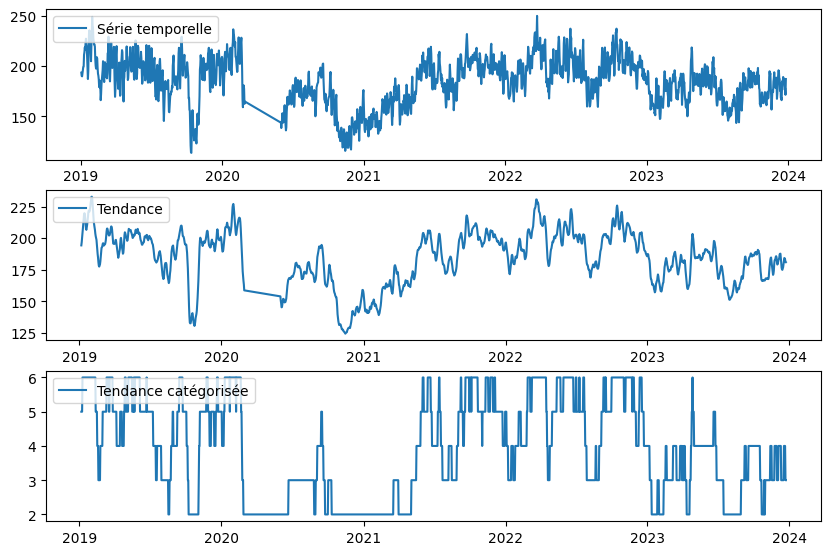

Amélioration avec max_depth=3: 100000.0000 -> 0.8564


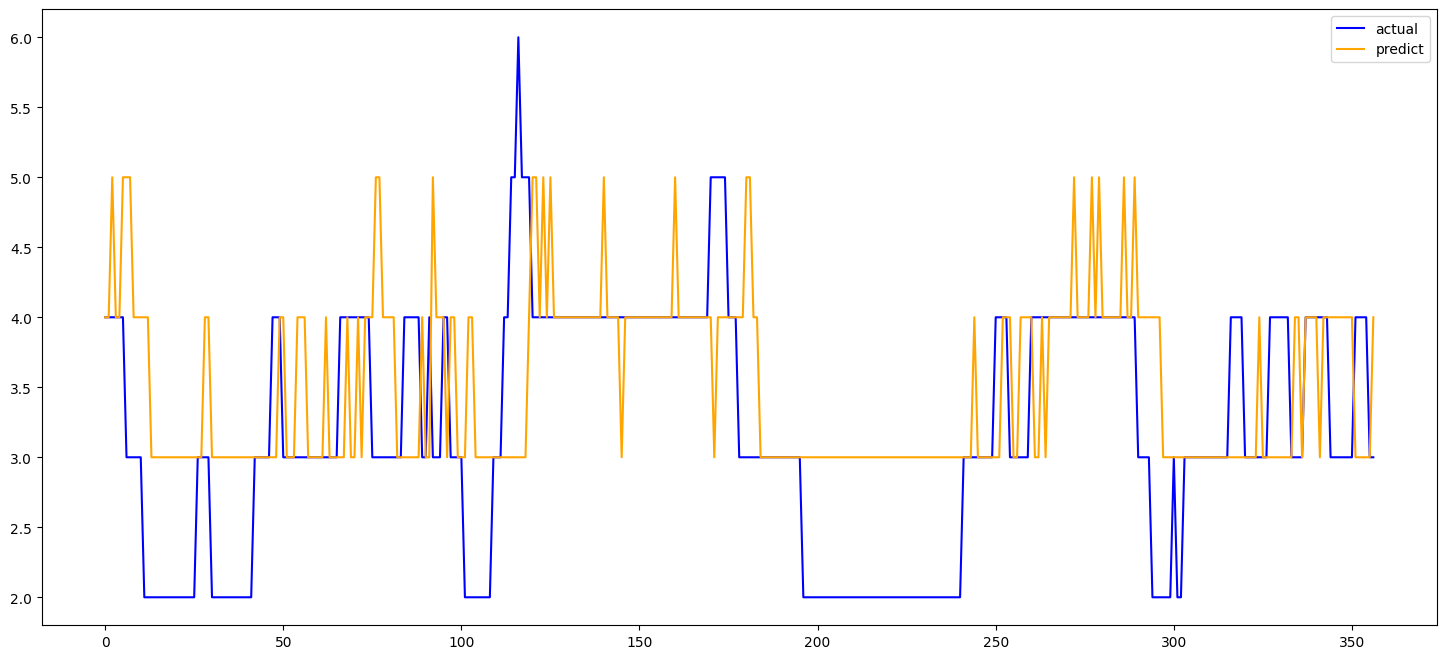

0.00%,1%
0.00%,2%
0.00%,3%
0.00%,4%
0.00%,5%
0.00%,6%
0.00%,7%
0.00%,8%
0.00%,9%
0.00%,10%
0.00%,11%
   - MAE : 0.74 (0.62 sur 2023)
   - MSE : 0.86 (0.74 sur 2023)
MAE: 20.90
best feature : nb_emmergencies%%mean_7J
                       feature        gain       cover  weight  importance  \
0     nb_emmergencies%%mean_7J  325.618469  633.538452    26.0    0.088029   
1    nb_emmergencies%%mean_14J  103.613014  634.200012    10.0    0.030269   
2                holidays%%J-1   76.631897  453.000000     1.0    0.020742   
3      trend_maladie%%std_365J   56.996445  470.181824    11.0    0.018521   
4              nb_emmergencies   29.451981  578.828552    35.0    0.018223   
..                         ...         ...         ...     ...         ...   
277            meteo_wspd%%J-6    0.194083   12.000000     1.0    0.000344   
278         trend_maladie%%J-2    0.066136   17.000000     1.0    0.000335   
279            meteo_tmax%%J-4    0.151633   11.000000     1.0    0.000330   
280 

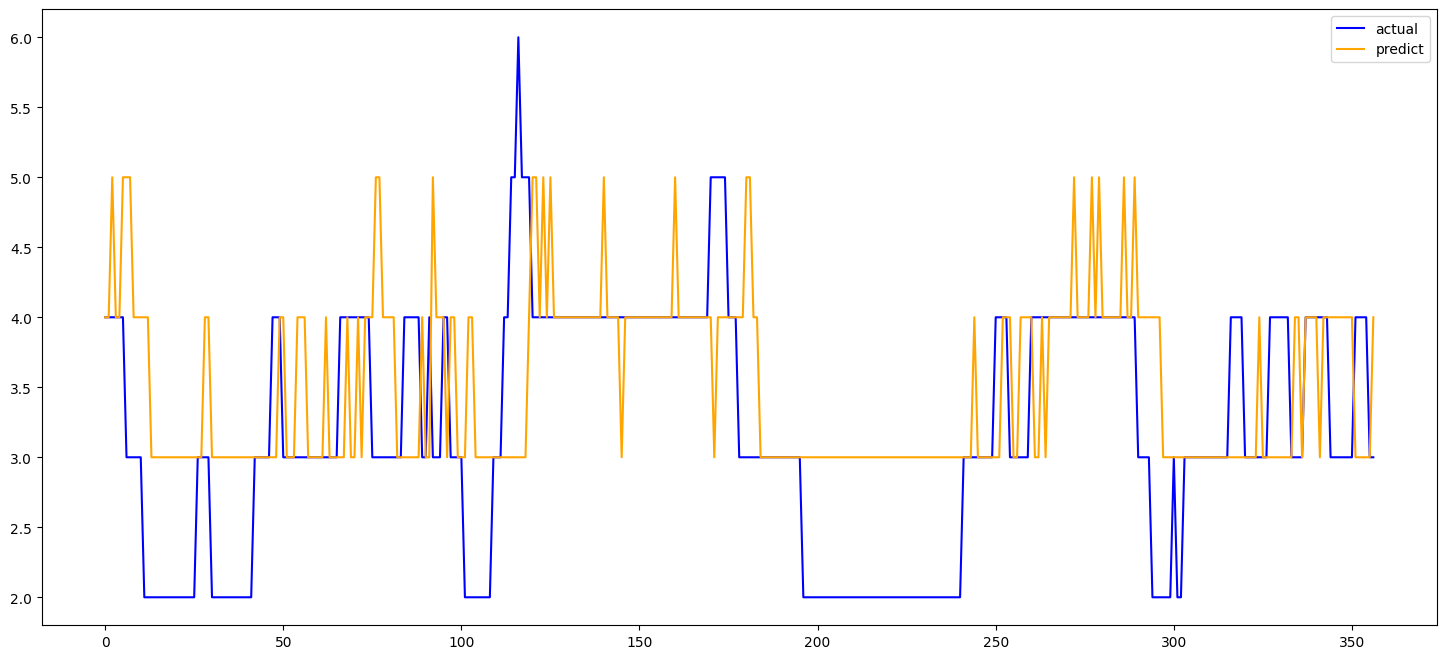

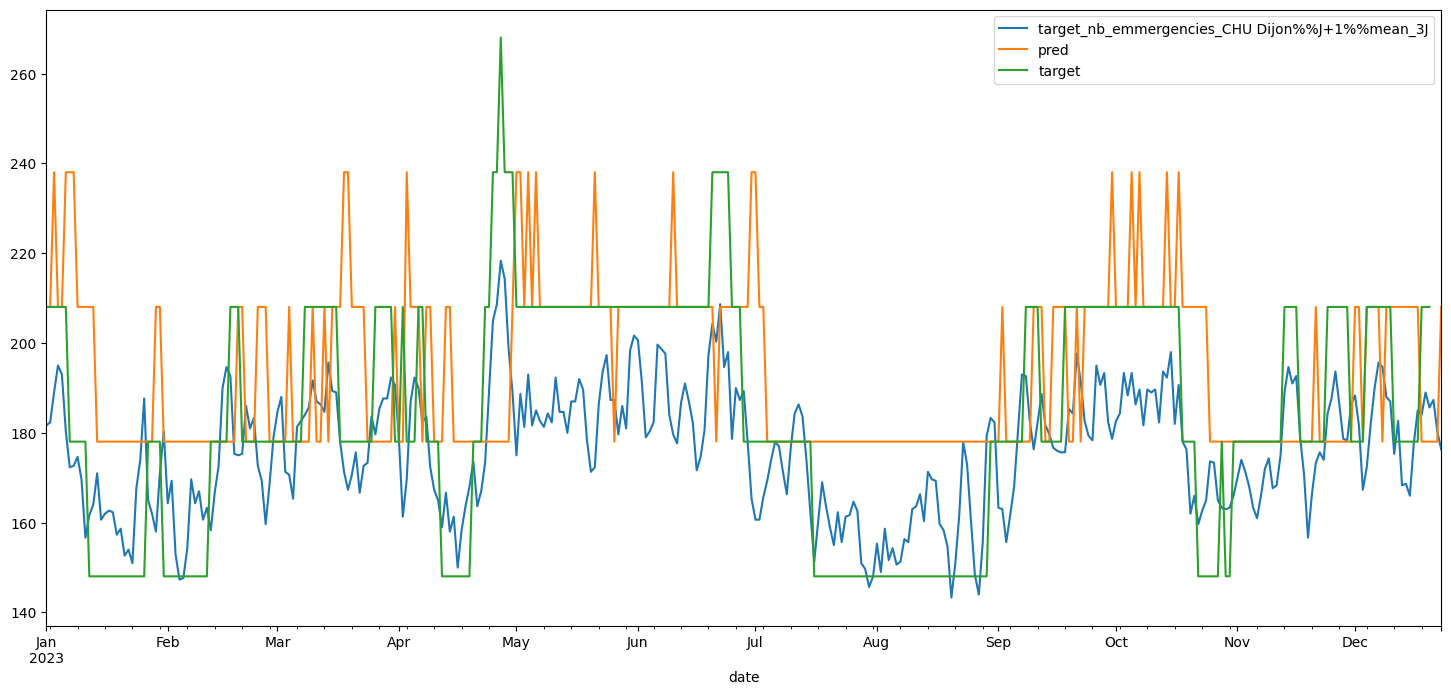

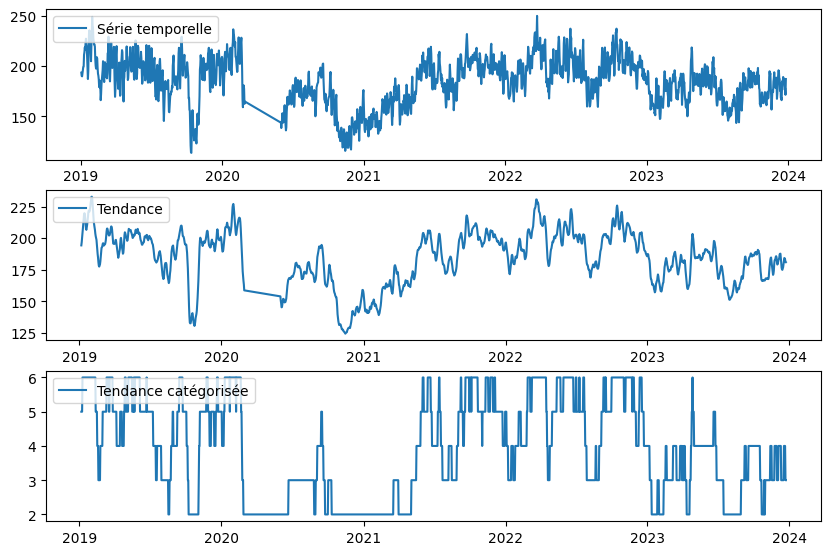

Amélioration avec max_depth=3: 100000.0000 -> 0.6512


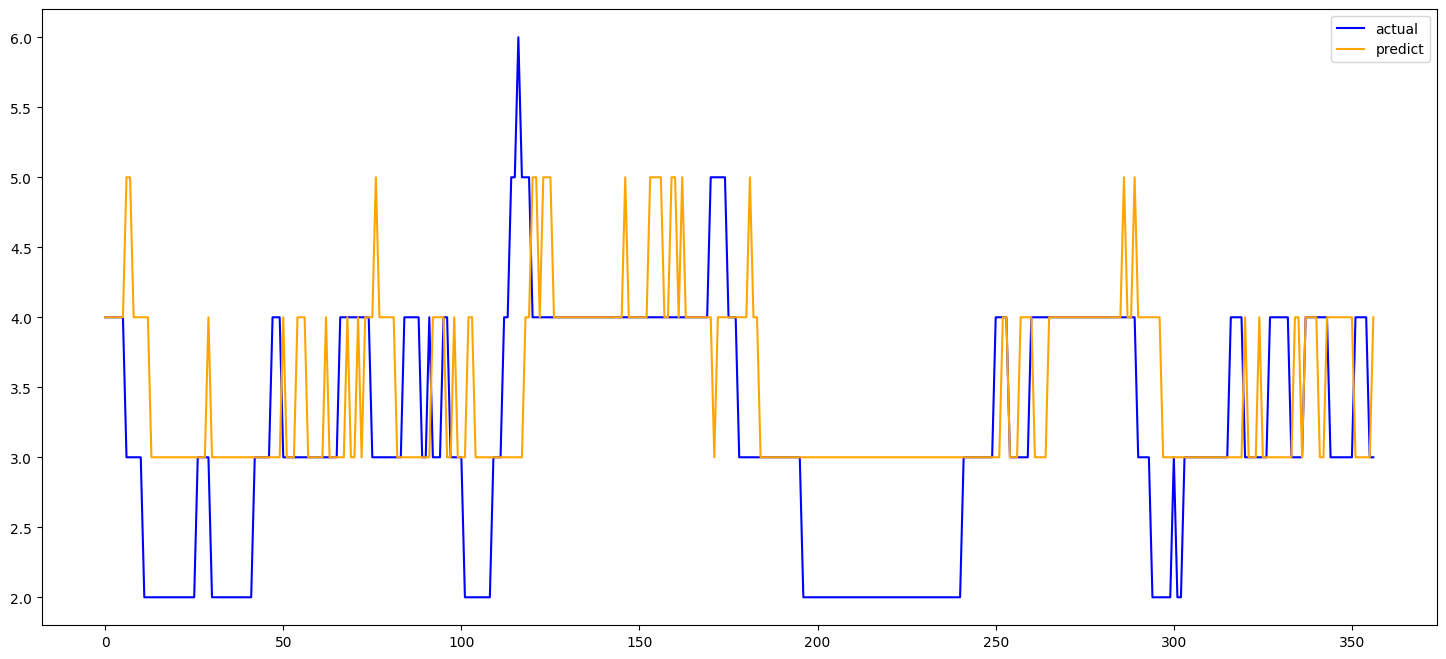

0.00%,1%
0.00%,2%
0.00%,3%
0.00%,4%
0.00%,5%
0.00%,6%
0.00%,7%
0.00%,8%
0.00%,9%
0.00%,10%
0.00%,11%
   - MAE : 0.64 (0.61 sur 2023)
   - MSE : 0.65 (0.71 sur 2023)
MAE: 20.55
best feature : nb_emmergencies%%mean_7J
                       feature        gain       cover  weight  importance  \
0     nb_emmergencies%%mean_7J  235.516846  471.388885    36.0    0.093464   
1    nb_emmergencies%%mean_14J   86.582794  479.166656    12.0    0.036450   
2      trend_maladie%%std_365J   61.788170  497.200012    10.0    0.027822   
3              nb_emmergencies   27.403513  527.810791    37.0    0.026732   
4         nb_emmergencies%%J-1   20.307812  586.444458    18.0    0.018005   
..                         ...         ...         ...     ...         ...   
119            meteo_tmin%%J-6    3.381695   38.000000     1.0    0.001777   
120      PM10_FR26014%%std_14J    2.528720   42.000000     1.0    0.001533   
121       trend_angine%%std_7J    2.054459   48.000000     1.0    0.001429   
122 

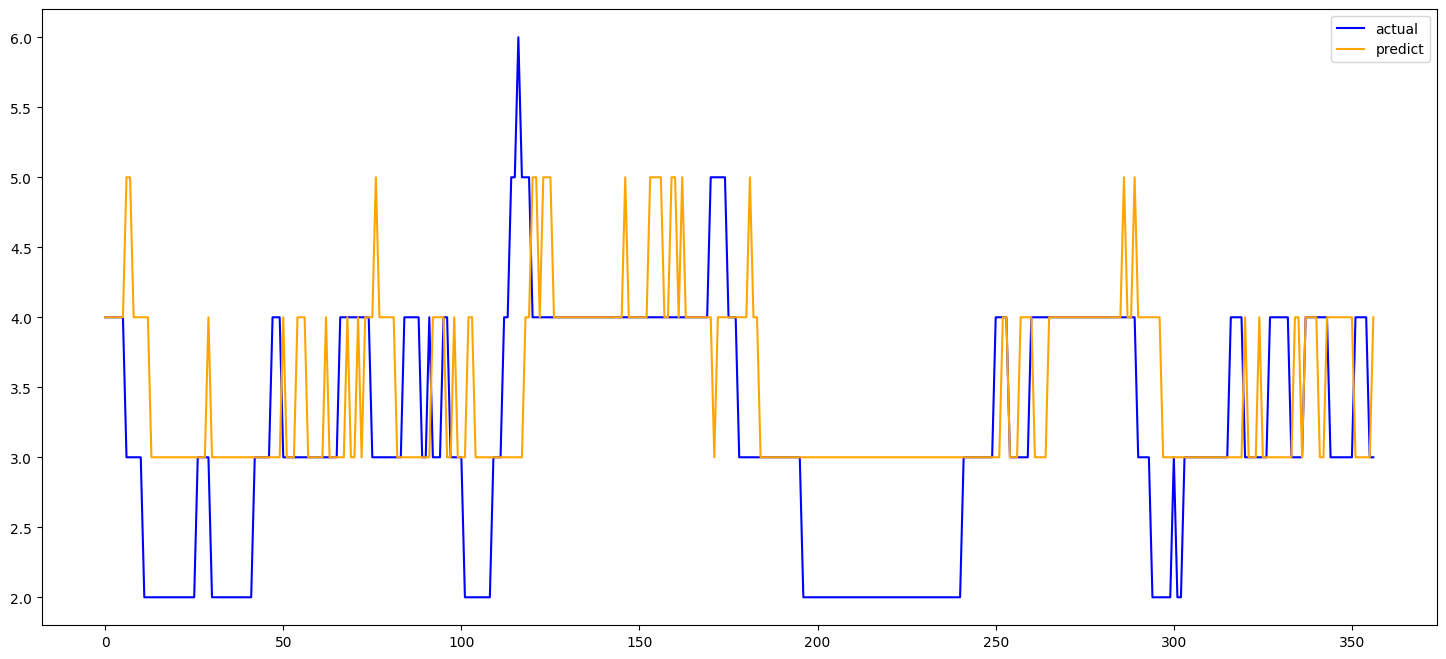

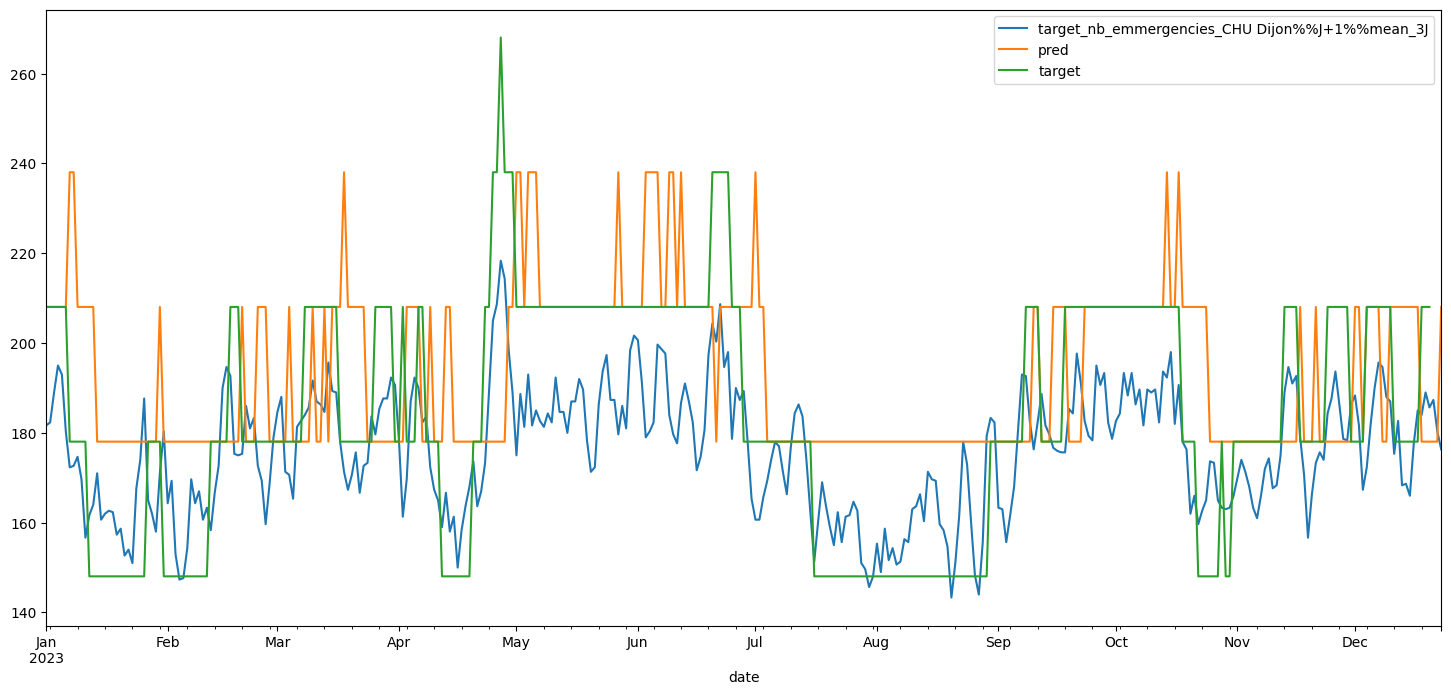

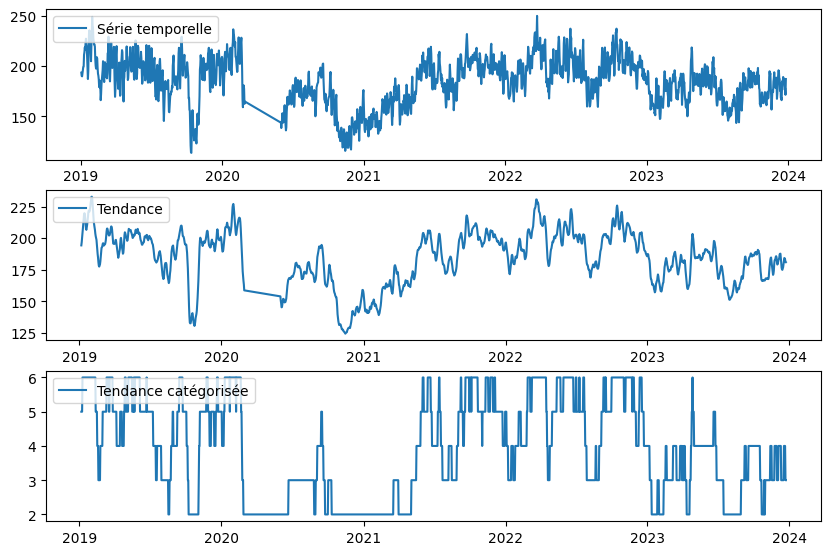

Amélioration avec max_depth=3: 100000.0000 -> 0.6711


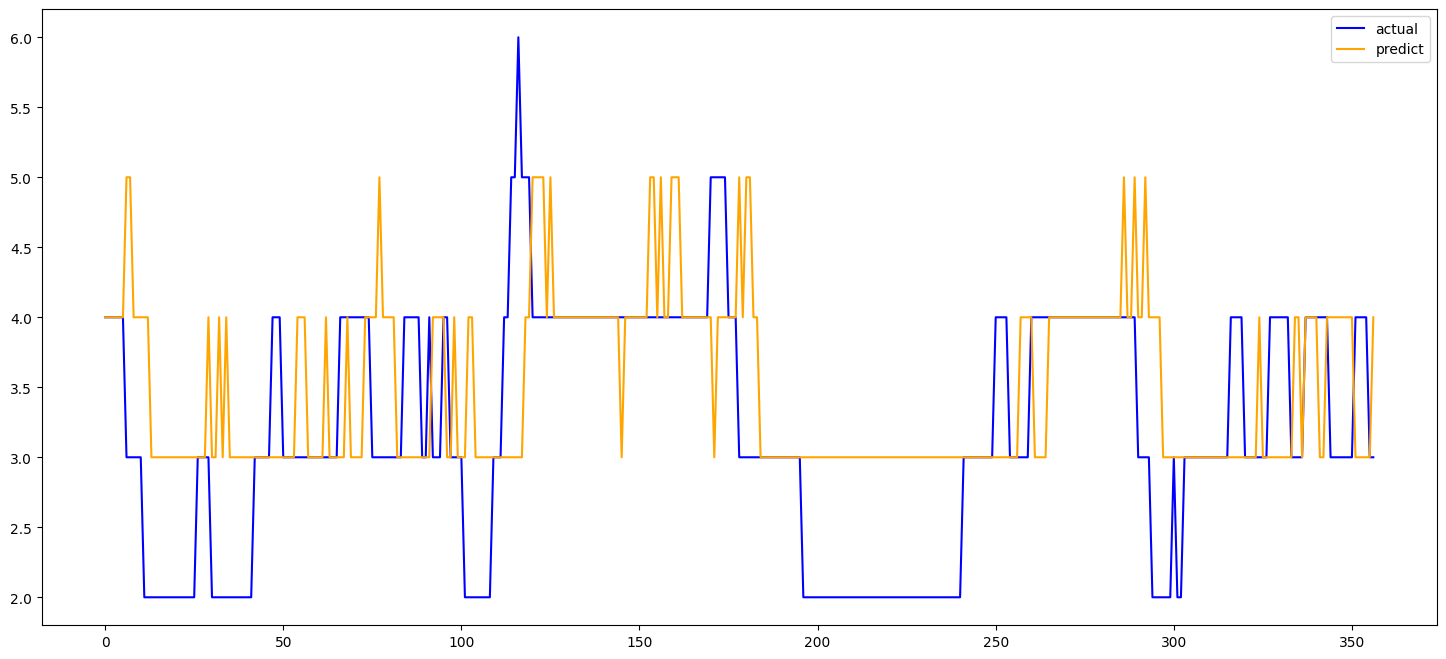

0.00%,1%
0.00%,2%
0.00%,3%
0.00%,4%
0.00%,5%
0.00%,6%
0.00%,7%
0.00%,8%
0.00%,9%
0.00%,10%
0.00%,11%
   - MAE : 0.65 (0.62 sur 2023)
   - MSE : 0.67 (0.75 sur 2023)
MAE: 20.42
best feature : nb_emmergencies%%mean_7J
                                              feature        gain       cover  \
0                            nb_emmergencies%%mean_7J  264.511810  520.343750   
1                           nb_emmergencies%%mean_14J   80.563095  516.692322   
2                                     nb_emmergencies   28.401785  549.263184   
3                             trend_maladie%%std_365J   51.727646  402.384613   
4                                            holidays   30.753263  315.461548   
5                                nb_emmergencies%%J-1   16.454332  545.578918   
6                                   inc_ira%%mean_31J   26.289679  244.500000   
7                                       holidays%%J-1   28.010853  459.000000   
8                               trend_vaccin%%std_31J  

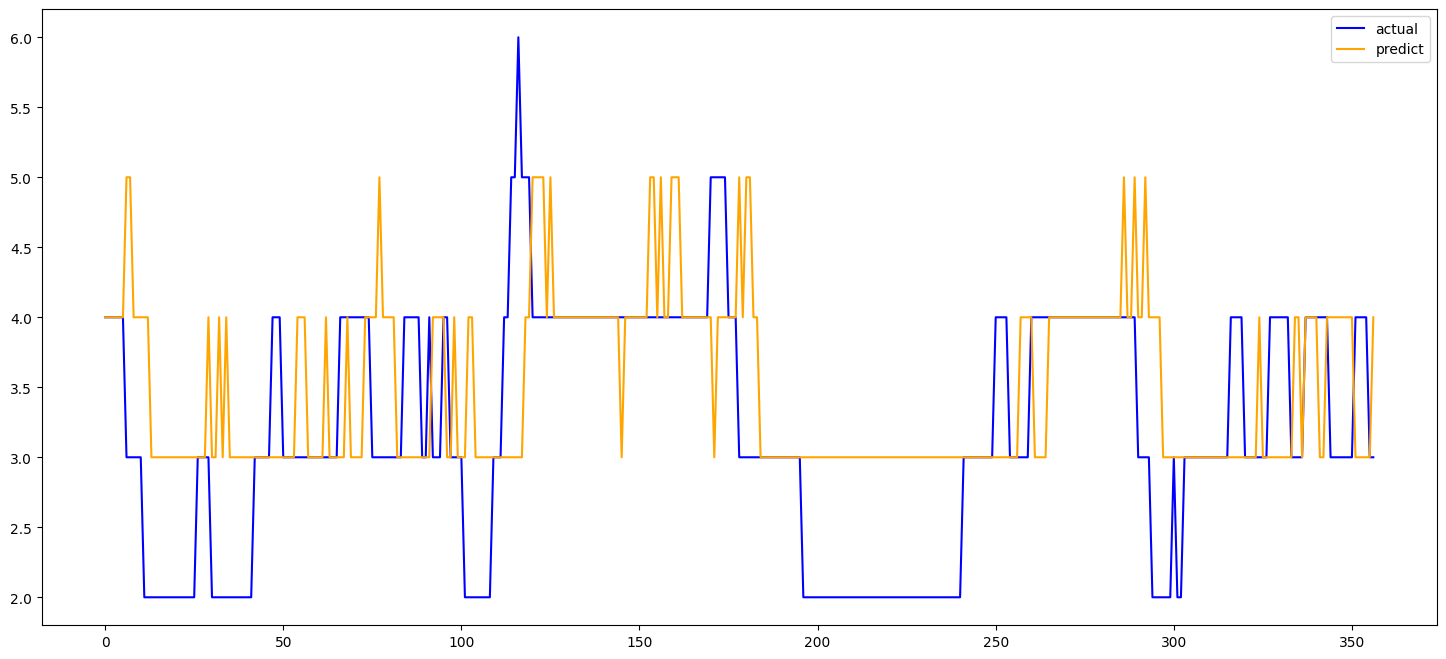

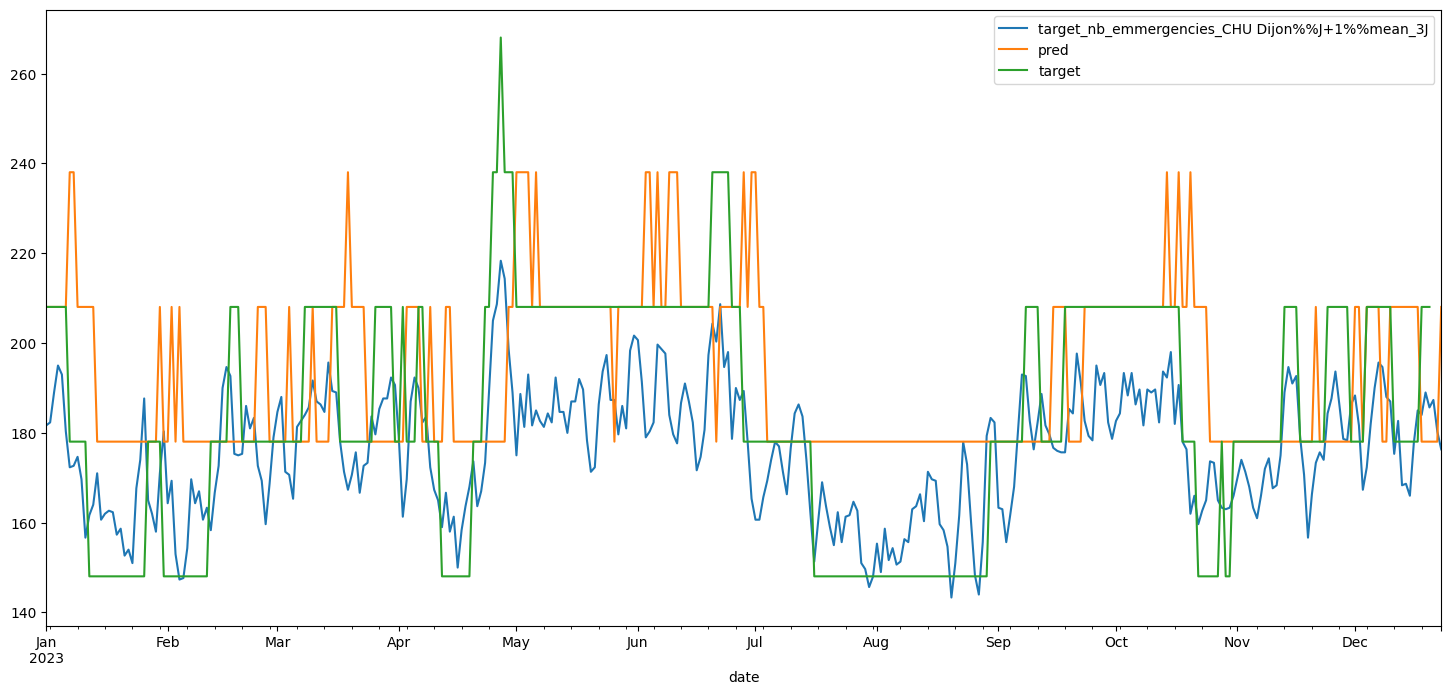

In [20]:
nb_features = len(arsTabularDataset.enc_data.columns) - 1
cols = arsTabularDataset.enc_data.columns
while nb_features > 50:
    # launche all process
    reg = process(arsTabularDataset, cols, show=True)


    # Un exemple pour déterminer l'importance des variables après un pré-apprentissage XGBoost
    importance_gain = reg.get_score(importance_type='gain')
    importance_cover = reg.get_score(importance_type='cover')
    importance_weight = reg.get_score(importance_type='weight')

    df_gain = pd.DataFrame.from_dict(importance_gain, orient='index', columns=['gain'])
    df_cover = pd.DataFrame.from_dict(importance_cover, orient='index', columns=['cover'])
    df_weight = pd.DataFrame.from_dict(importance_weight, orient='index', columns=['weight'])

    di = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
    di.fillna(0, inplace=True)  # Remplacer les valeurs manquantes par 0 si nécessaire

    di = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
    di.fillna(0, inplace=True)  # Remplacer les valeurs manquantes par 0 si nécessaire

    di['gain_norm'] = di['gain'] / di['gain'].sum()
    di['cover_norm'] = di['cover'] / di['cover'].sum()
    di['weight_norm'] = di['weight'] / di['weight'].sum()

    w_gain = 0.5
    w_cover = 0.3
    w_weight = 0.2

    di['importance'] = (di['gain_norm'] * w_gain) + (di['cover_norm'] * w_cover) + (di['weight_norm'] * w_weight)

    di.sort_values(by='importance', ascending=False, inplace=True)
    di['rank'] = di['importance'].rank(ascending=False)

    di.reset_index(inplace=True)
    di.rename(columns={'index': 'feature'}, inplace=True)
    print('best feature :', di.loc[di['rank'] == 1, 'feature'].values[0])
    print(di[['feature', 'gain', 'cover', 'weight', 'importance', 'rank']])
    cols = di.loc[di['rank'] < int(len(di)/2), 'feature']
    nb_features = len(cols)
